# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import numpy as np

import torch.utils.data as data

from torch import nn

from src.util.hsi import (
    extract_patches,
    DimReductionType,
    PreProcessType,
    preprocess_hsi,
    reduce_hsi_dim,
    read_fixed_labels_mask,
    train_test_split_by_mask,
)
from src.util.torch import resolve_torch_device
from src.data.indian_pines import load_indian_pines
from src.visualization.plot import (
    plot_segmentation_comparison,
    plot_epoch_generic,
    plot_masked_segmentation_comparison,
)
from src.data.dataset_decorator import UnlabeledDatasetDecorator, BinaryDatasetDecorator
from src.model.lenet import PuLeNet
from src.trainer.multiview_trainer import MultiViewTrainer
from src.model.ensemble import MultiViewEnsemble
from src.trainer.base_trainer import AdamOptimizedModule
from src.trainer.classification_trainer import ClassificationTrainer
from src.util.reporting import (
    classification_trainer,
    create_model_name,
    report_run,
    read_report_to_show,
)
from src.util.dict_ext import arrange_and_repeat

2. Prepare env

In [2]:
learning_rate = 1e-3
num_epochs = 30
scheduler_step_size = num_epochs
scheduler_gamma = 0.9
weight_decay = 0

In [3]:
batch_size = 32
patch_size = 9
target_dim = 75

pre_process_type = PreProcessType.STANDARTIZATION
dim_reduction_type = DimReductionType.PCA

In [4]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

generator = torch.Generator()
generator.manual_seed(random_seed)

In [5]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [6]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [7]:
_, image = preprocess_hsi(image, pre_process_type)

In [8]:
num_classes = len(np.unique(labels))

f"Number of classes {num_classes}"

'Number of classes 17'

In [9]:
examples_per_class = arrange_and_repeat(num_classes, 20)

4. Reduce dimensions

In [10]:
_, target_dim, image = reduce_hsi_dim(
    image, target_dim, dim_reduction_type, device, random_seed
)

5. Prepare dataset

In [11]:
x, y = extract_patches(image, labels, patch_size=patch_size)

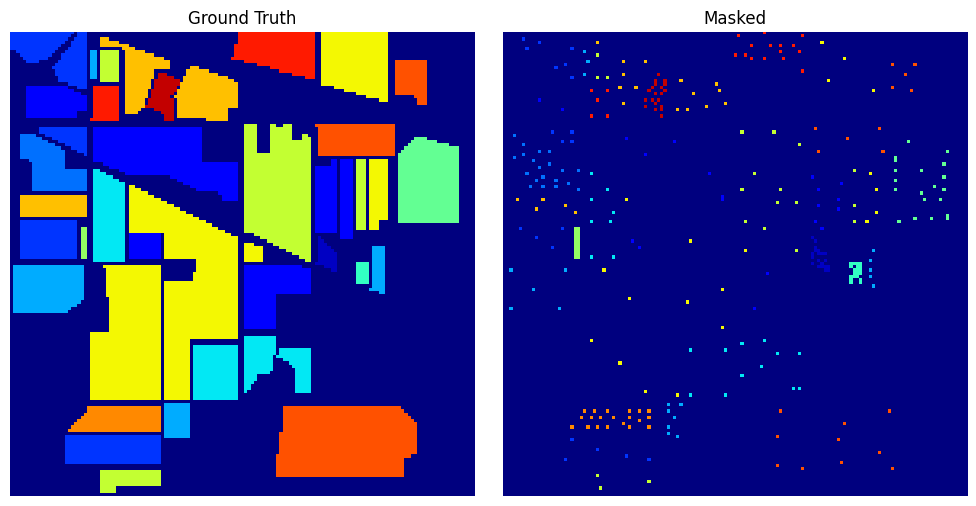

In [12]:
mask = read_fixed_labels_mask("indian-pines-v1.npy")

x_train, y_train, x_test, y_test = train_test_split_by_mask(x, y, mask)

_ = plot_masked_segmentation_comparison(y.reshape(image_h, image_w), mask)

In [13]:
x_all = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2)
y_all = torch.tensor(y, dtype=torch.int32)
x_train = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train = torch.tensor(y_train, dtype=torch.int32)
x_test = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test = torch.tensor(y_test, dtype=torch.int32)

In [14]:
train_dataset = data.TensorDataset(x_train, y_train)
test_dataset = data.TensorDataset(x_test, y_test)
full_dataset = data.TensorDataset(x_all, y_all)

In [15]:
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)
unlabeled_loader = data.DataLoader(
    UnlabeledDatasetDecorator(test_dataset),
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)
full_loader = data.DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)

6. Train semi-supervised model

In [16]:
from src.model.dbda_v2 import DbdaWithCrossAttention


models = []
trainers = []
labeled = []

for i in range(1, num_classes):
    model = AdamOptimizedModule(
        DbdaWithCrossAttention(band=target_dim, classes=1, flatten_out=True),
        lr=learning_rate,
        weight_decay=weight_decay,
    )
    loss = nn.BCEWithLogitsLoss()
    trainer = ClassificationTrainer(
        num_epochs=num_epochs,
        num_classes=num_classes,
        criterion=loss,
        device=device,
        record_history=False,
        dl_accumulation_steps=2
    )

    models.append(model)
    trainers.append(trainer)
    labeled.append(
        data.DataLoader(
            BinaryDatasetDecorator(train_dataset, i),
            batch_size=batch_size,
            shuffle=True,
            generator=generator,
        )
    )

co_trainer = MultiViewTrainer(
    num_classes=num_classes,
    confidence_threshold=0.9,
    device=device,
    max_epochs=3
)

In [17]:
feedback, co_trained = co_trainer.fit(
    models=models,
    trainers=trainers,
    labeled=labeled,
    unlabeled=unlabeled_loader,
    ensemble_eval_dl=test_loader,
)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

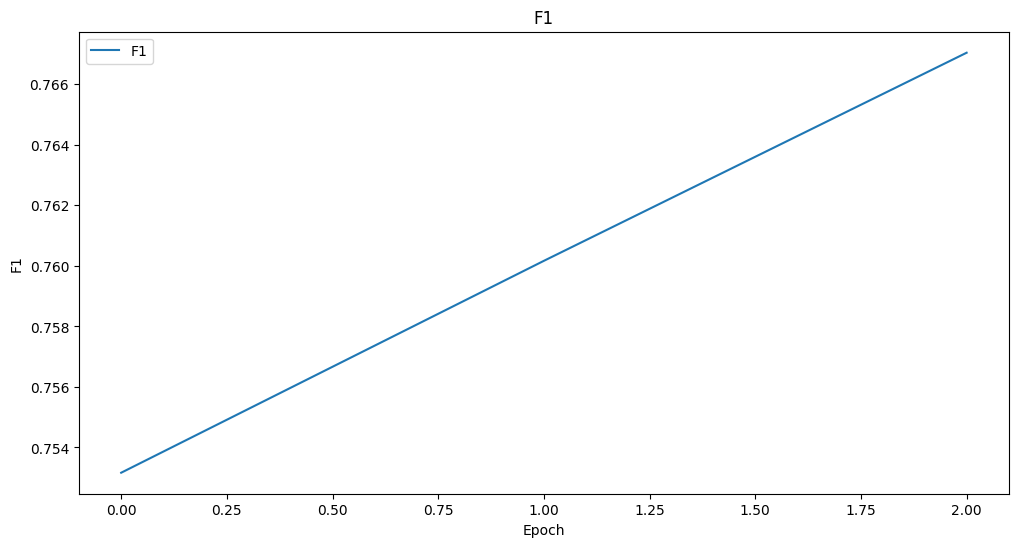

In [18]:
plot_epoch_generic([it.eval["eval_f1"] for it in feedback.history], desc="F1")

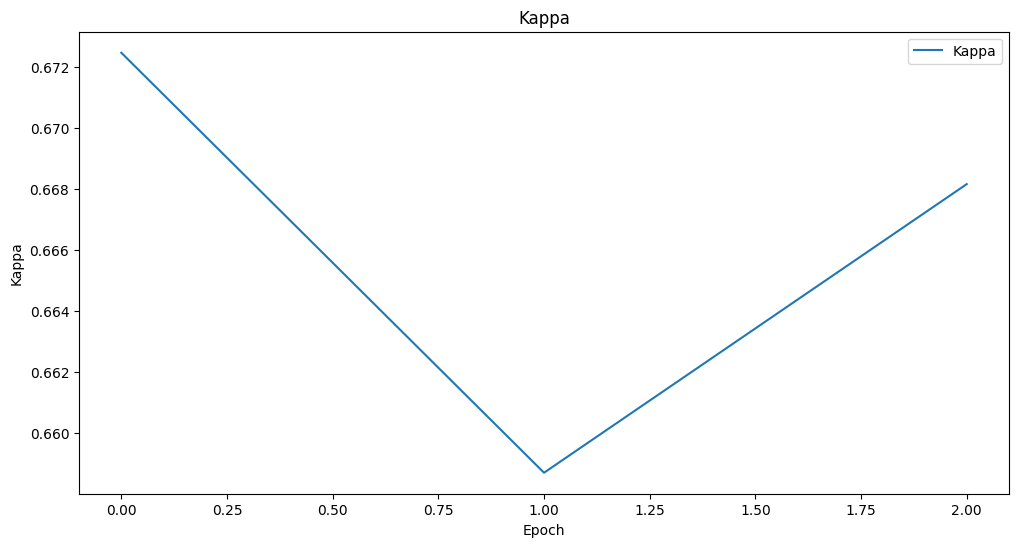

In [19]:
plot_epoch_generic([it.eval["eval_kappa"] for it in feedback.history], desc="Kappa")

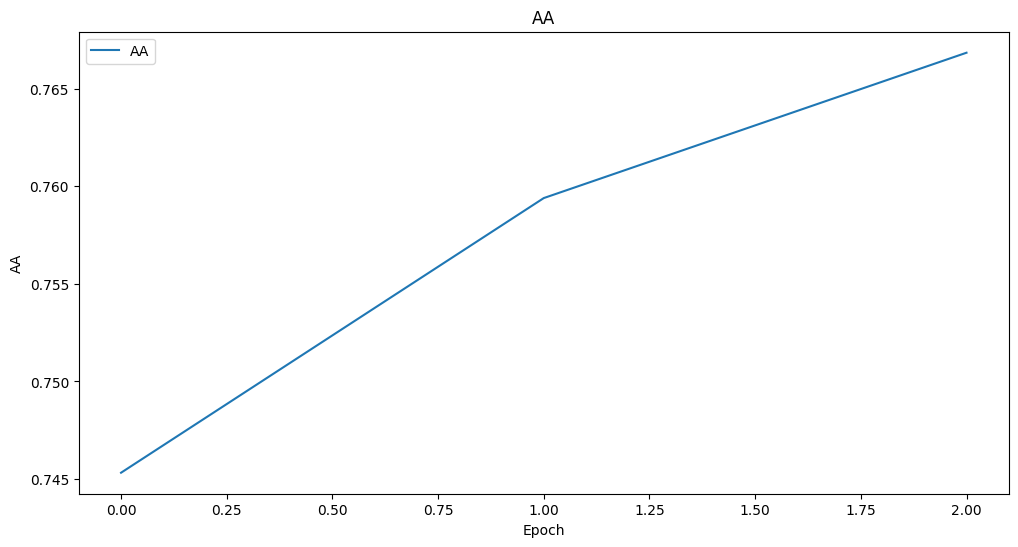

In [20]:
plot_epoch_generic(
    [it.eval["eval_accuracy_avg"] for it in feedback.history], desc="AA"
)

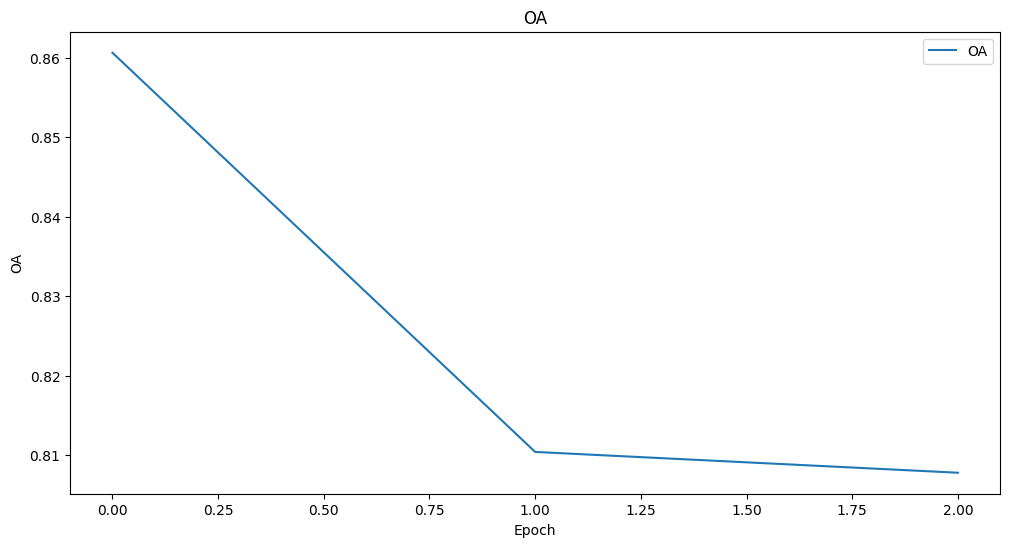

In [21]:
plot_epoch_generic(
    [it.eval["eval_accuracy_overall"] for it in feedback.history], desc="OA"
)

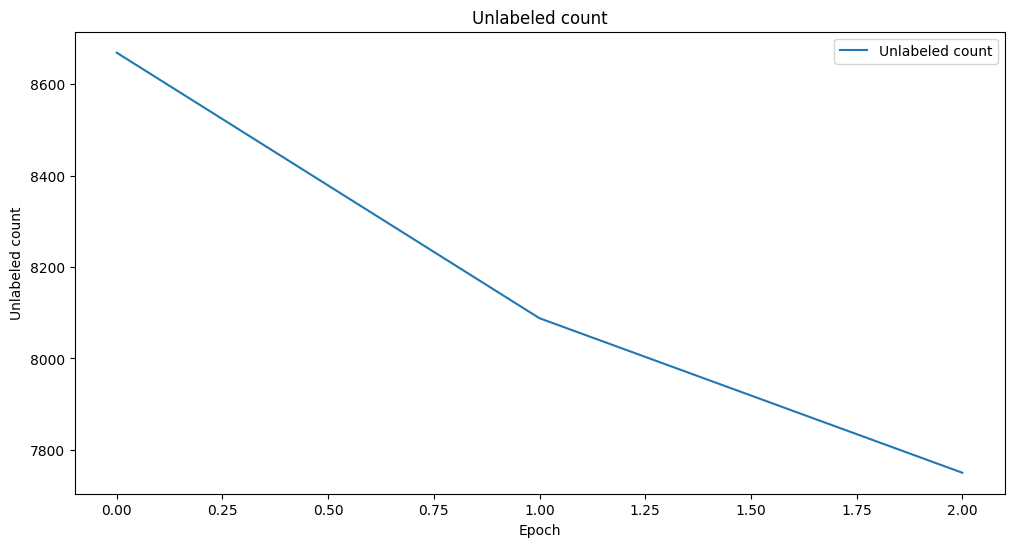

In [22]:
plot_epoch_generic(
    [it.train["unlabeled_len"] for it in feedback.history], desc="Unlabeled count"
)

In [23]:
co_trained = MultiViewEnsemble(models, confidence_treshhold=0.9)

In [24]:
validation_result = co_trainer.validate(co_trained, full_loader)

validation_result

{'eval_f1': 0.7707229852676392,
 'eval_accuracy_overall': 0.8606936931610107,
 'eval_accuracy_avg': 0.7733650207519531,
 'eval_kappa': 0.6766137480735779}

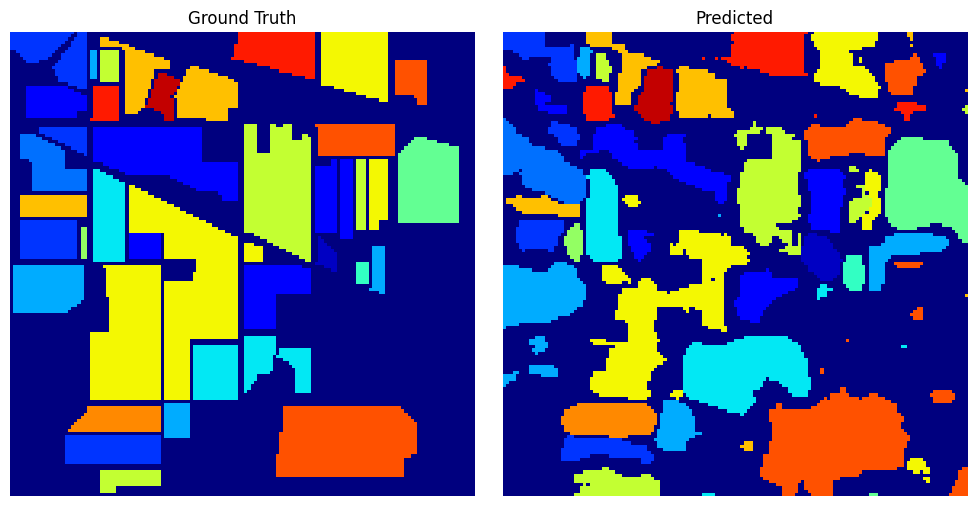

In [25]:
_, y_pred = co_trainer.predict(co_trained, predict_loader)
y_pred = torch.cat(y_pred, dim=0)
y_pred = y_pred.reshape(image_h, image_w)

plot_segmentation_comparison(labels, y_pred.cpu().numpy())

6. Write report

In [26]:
model_name = create_model_name("indian_pines_", examples_per_class)
model_category = "lenet_multiview"

In [27]:
run_params = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "patch_size": patch_size,
    "target_dim": target_dim,
    "pre_process_type": str(pre_process_type),
    "dim_reduction_type": str(dim_reduction_type),
}

report_run(
    model_name=model_name,
    model_category=model_category,
    run_desc="DBDA_v2, 3 epochs, new unlabled shrinking, more epochs",
    run_params=run_params | model.get_params(),
    run_metrics=classification_trainer(validation_result),
)

PosixPath('/home/melal/Workspace/spatial-regulated-self-training/reports/runs/indian_pines__0-20_1-20_2-20_3-20_4-20_5-20_6-20_7-20_8-20_9-20_10-20_11-20_12-20_13-20_14-20_15-20_16-20.csv')

In [28]:
read_report_to_show(model_name, sort_by_metric="f1")

,timestamp,model_category,run_desc,params,loss,f1,OA,AA,kappa
67,2025-05-31T18:17:32.920559+00:00,lenet_multiview,"New fixed mask, 2 epoch, new unlabled shrinking","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.790402,0.878032,0.787206,0.703928
64,2025-05-31T12:52:12.314211+00:00,lenet_multiview,"New fixed mask, 2 epochs, new unlabled shrinking","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.790402,0.878032,0.787206,0.703928
81,2025-06-03T12:14:50.003049+00:00,lenet_multiview,"DBDA_v2, 3 epochs, new unlabled shrinking, mor...","{""num_epochs"": 30, ""batch_size"": 32, ""patch_si...",NaN,0.770723,0.860694,0.773365,0.676614
62,2025-05-30T20:38:12.198151+00:00,lenet_multiview,"New fixed mask, less epochs","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.761022,0.824273,0.768847,0.657544
72,2025-06-01T11:04:28.706267+00:00,lenet_multiview,"Self learning, 8 epochs, new unlabled shrinkin...","{""num_epochs"": 30, ""batch_size"": 32, ""patch_si...",NaN,0.760632,0.838244,0.765612,0.657339
...,...,...,...,...,...,...,...,...,...
22,2025-05-25T14:39:13.847478+00:00,specteal_former_co_training,Default run,"{""hidden_dim"": 32, ""num_layers"": 5, ""num_heads...",2.814270,0.179225,0.430531,0.176266,0.130307
10,2025-05-25T09:30:05.188620+00:00,vit,Add weight decay,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",5.515652,0.177391,0.052552,0.143306,0.060421
73,2025-06-01T20:02:30.458685+00:00,vit,"Fixed mask, add weight decay, increase dropout...","{""num_epochs"": 300, ""batch_size"": 64, ""patch_s...",2.716200,0.168771,0.048153,0.131034,0.049644
24,2025-05-25T16:13:53.131416+00:00,lenet_co_training,"Less epochs, no scheduling","{""learning_rate"": 0.001, ""num_epochs"": 30, ""ba...",2.827521,0.147750,0.677064,0.252176,0.225479


In [29]:
read_report_to_show(model_name, sort_by_metric="f1", model_category=model_category)

,timestamp,run_desc,params,loss,f1,OA,AA,kappa
67,2025-05-31T18:17:32.920559+00:00,"New fixed mask, 2 epoch, new unlabled shrinking","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.790402,0.878032,0.787206,0.703928
64,2025-05-31T12:52:12.314211+00:00,"New fixed mask, 2 epochs, new unlabled shrinking","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.790402,0.878032,0.787206,0.703928
81,2025-06-03T12:14:50.003049+00:00,"DBDA_v2, 3 epochs, new unlabled shrinking, mor...","{""num_epochs"": 30, ""batch_size"": 32, ""patch_si...",NaN,0.770723,0.860694,0.773365,0.676614
62,2025-05-30T20:38:12.198151+00:00,"New fixed mask, less epochs","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.761022,0.824273,0.768847,0.657544
72,2025-06-01T11:04:28.706267+00:00,"Self learning, 8 epochs, new unlabled shrinkin...","{""num_epochs"": 30, ""batch_size"": 32, ""patch_si...",NaN,0.760632,0.838244,0.765612,0.657339
63,2025-05-31T12:39:48.464309+00:00,"New fixed mask, more epochs, new unlabled shri...","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.758548,0.828754,0.762759,0.654074
80,2025-06-03T11:23:38.781357+00:00,"DBDA_v2, 8 epochs, new unlabled shrinking, mor...","{""num_epochs"": 30, ""batch_size"": 32, ""patch_si...",NaN,0.751909,0.835750,0.759667,0.651566
57,2025-05-30T14:30:57.399895+00:00,"Fixed mask, less epochs","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.751540,0.816561,0.758763,0.645057
55,2025-05-29T18:14:30.557523+00:00,DBDA,"{""learning_rate"": 0.001, ""num_epochs"": 15, ""ba...",NaN,0.747156,0.815115,0.749727,0.637652
65,2025-05-31T15:05:38.989875+00:00,"New fixed mask, 8 epochs, new unlabled shrinki...","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.723802,0.840337,0.725660,0.610802
